# パッケージインストール

In [ ]:
!pip install git+https://github.com/LLaVA-VL/LLaVA-NeXT.git -q
!pip install -q flash_attn
!pip install -q -U transformers

# モデル読み込み

In [ ]:
from llava.model.builder import load_pretrained_model

device = "cuda"

pretrained = "AI-Safeguard/Ivy-VL-llava"
model_name = "llava_qwen"
tokenizer, model, image_processor, max_length = load_pretrained_model(
    pretrained,
    None,
    model_name,
    device_map="auto",
)

model.eval()

# サンプル画像ダウンロード

In [3]:
!wget https://user0514.cdnw.net/shared/img/thumb/zzzDSC_0746_TP_V4.jpg -O sample.jpg

--2024-12-11 14:40:31--  https://user0514.cdnw.net/shared/img/thumb/zzzDSC_0746_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.105.216.58
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.105.216.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96322 (94K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  94.06K   421KB/s    in 0.2s    

2024-12-11 14:40:31 (421 KB/s) - ‘sample.jpg’ saved [96322/96322]



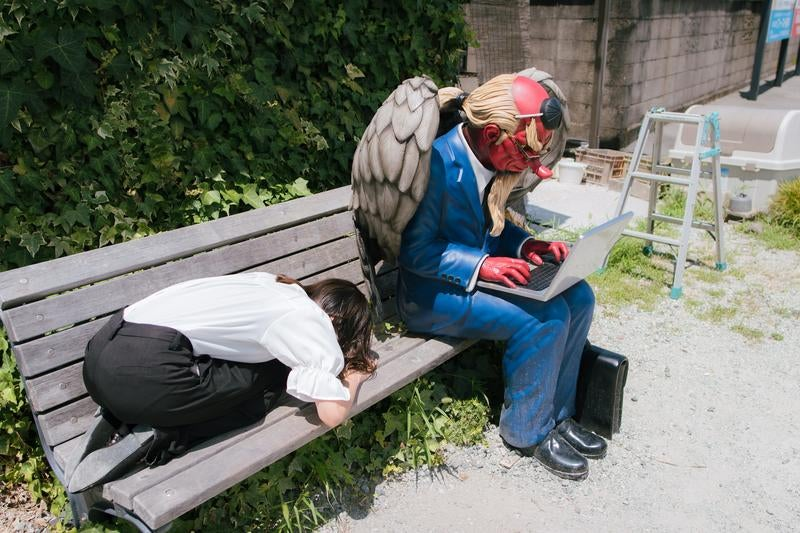

In [4]:
from PIL import Image

image = Image.open("sample.jpg")
image

# 画像認識

In [5]:
from llava.constants import DEFAULT_IMAGE_TOKEN

question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"

In [6]:
import copy
import torch
from llava.constants import IMAGE_TOKEN_INDEX
from llava.conversation import conv_templates
from llava.mm_utils import process_images, tokenizer_image_token

# 画像前処理
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

# プロンプト準備
conv_template = "qwen_1_5"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(
    prompt_question,
    tokenizer,
    IMAGE_TOKEN_INDEX,
    return_tensors="pt",
).unsqueeze(0).to(device)
image_sizes = [image.size]

In [7]:
%%time

# 推論
cont = model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.

CPU times: user 3.05 s, sys: 72.3 ms, total: 3.13 s
Wall time: 4.4 s


In [8]:
print(text_outputs)

['A statue of a man sitting on a bench using a laptop while another person lies down beside him.']
